In [1]:
import argparse
import torch

import wandb
import numpy as np
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer
from sklearn.mixture import BayesianGaussianMixture

/home/an/miniconda3/envs/ndg/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/an/miniconda3/envs/ndg/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.resume:
        cfg.RESUME = args.resume

    if args.seed:
        cfg.SEED = args.seed

    if args.source_domains:
        cfg.DATASET.SOURCE_DOMAINS = args.source_domains

    if args.target_domains:
        cfg.DATASET.TARGET_DOMAINS = args.target_domains

    if args.transforms:
        cfg.INPUT.TRANSFORMS = args.transforms

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    if args.backbone:
        cfg.MODEL.BACKBONE.NAME = args.backbone

    if args.head:
        cfg.MODEL.HEAD.NAME = args.head

    #if args.uncertainty:
    cfg.MODEL.UNCERTAINTY = args.uncertainty

    #if args.pos:
    cfg.MODEL.POS = args.pos
    cfg.USE_CUDA = False
    
def setup_cfg(args):
    cfg = get_cfg_default()
    reset_cfg(cfg, args)
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    return cfg

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./DATA', help='path to dataset')
parser.add_argument(
    '--output-dir', type=str, default='../output/dg/vlcs/baseline/verify2/labelme_pascal-caltech', help='output directory'
)
parser.add_argument(
    '--resume',
    type=str,
    default='',
    help='checkpoint directory (from which the training resumes)'
)
parser.add_argument(
    '--seed',
    type=int,
    default=1,
    help='only positive value enables a fixed seed'
)
parser.add_argument(
    '--source-domains',
    type=str,
    nargs='+',
    default='labelme pascal'.split(),
    help='source domains for DA/DG'
)
parser.add_argument(
    '--target-domains',
    type=str,
    nargs='+',
    default=['sun'],
    help='target domains for DA/DG'
)
parser.add_argument(
    '--transforms', type=str, nargs='+', help='data augmentation methods'
)
parser.add_argument(
    '--config-file', type=str, default='../configs/trainers/dg/vanilla/vlcs.yaml', help='path to config file'
)
parser.add_argument(
    '--dataset-config-file',
    type=str,
    default='../configs/datasets/dg/vlcs.yaml',
    help='path to config file for dataset setup'
)
parser.add_argument(
    '--trainer', type=str, default='Vanilla', help='name of trainer'
)
parser.add_argument(
    '--backbone', type=str, default='', help='name of CNN backbone'
)
parser.add_argument('--head', type=str, default='', help='name of head')
parser.add_argument(
    '--eval-only', action='store_true', help='evaluation only'
)
parser.add_argument(
    '--model-dir',
    type=str,
    default='',
    help='load model from this directory for eval-only mode'
)
parser.add_argument(
    '--load-epoch',
    type=int,
    help='load model weights at this epoch for evaluation'
)
parser.add_argument(
    '--no-train', action='store_true', help='do not call trainer.train()'
)
parser.add_argument(
    'opts',
    default=None,
    nargs=argparse.REMAINDER,
    help='modify config options using the command-line'
)
parser.add_argument('--uncertainty', default=0.0, type=float)
parser.add_argument('--pos', nargs='+', type=int, default=[],
                    help='pos for uncertainty')
parser.add_argument('--wandb', default=0, type=int, help='visualize on Wandb')
parser.add_argument('--option', default='', type=str, help='additional options')
parser.add_argument('--update_interval', default=20, type=int, help='update cluster interval')

args = parser.parse_args('')

In [4]:
cfg = setup_cfg(args)
if args.wandb:
    if 'u' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'DSU'
    elif 'c' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'ConstStyle'
    else:
        job_type = 'Baseline'
    if cfg.MODEL.BACKBONE.PRETRAINED:
        job_type += '-pretrained'
        
    tracker = wandb.init(
        project = 'StyleDG',
        entity = 'aiotlab',
        config = args,
        group = f'{cfg.DATASET.NAME}',
        name = f'train={cfg.DATASET.SOURCE_DOMAINS}_test={cfg.DATASET.TARGET_DOMAINS}_type={args.option}',
        job_type = job_type
    )
    args.tracker = tracker

if cfg.SEED >= 0:
    print('Setting fixed seed: {}'.format(cfg.SEED))
    set_random_seed(cfg.SEED)
setup_logger(cfg.OUTPUT_DIR)

if torch.cuda.is_available() and cfg.USE_CUDA:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

trainer = build_trainer(cfg, args)

Setting fixed seed: 1
Loading trainer: Vanilla
<class 'dassl.engine.dg.vanilla.Vanilla'>
Loading dataset: VLCS
Building transform_train
+ resize to 224x224
+ random flip
+ random translation
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building transform_test
+ resize to 224x224
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
***** Dataset statistics *****
  Dataset: VLCS
  Source domains: ['labelme', 'pascal']
  Target domains: ['sun']
  # classes: 5
  # train_x: 3,799
  # val: 423
  # test: 985
Building model
Backbone: resnet18
# params: 11,179,077
Loading evaluator: Classification


In [5]:
# trainer.load_model(cfg.OUTPUT_DIR, epoch=5)

Loading weights to model from "../output/dg/vlcs/baseline/verify2/labelme_pascal-caltech/model/model.pth.tar-5" (epoch = 5)
Do evaluation on test set
=> result
* total: 985
* correct: 659
* current accuracy: 66.90%
* best accuracy: 66.90%
* error: 33.10%


/home/an/nduong/DG/DSU/multi-domain-generalization/dassl/utils/torchtools.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fpath, map_location=ma

In [5]:
trainer.test()

Do evaluation on test set
=> result
* total: 985
* correct: 97
* current accuracy: 9.85%
* best accuracy: 9.85%
* error: 90.15%


OrderedDict([('accuracy', 9.847715736040609),
             ('error_rate', 90.15228426395939),
             ('best_accuracy', 9.847715736040609)])

In [6]:
# For calculating distance
id_mean = []
id_std = []
id_domains = []
train_loader_x = trainer.train_loader_x
for idx, batch in enumerate(train_loader_x):
    images, label = trainer.parse_batch_train(batch)
    domain = batch['domain']
    style_feat = trainer.model.backbone.stylemaps(images)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    id_mean.extend(mean)
    id_std.extend(std)
    id_domains.extend(domain.numpy())
total_id_feats = len(id_domains)

od_mean = []
od_std = []
od_domains = []
test_loader = trainer.test_loader
for idx, batch in enumerate(test_loader):
    images, label = trainer.parse_batch_train(batch)
    od_domains.extend([3 for i in range(len(label))])
    style_feat = trainer.model.backbone.stylemaps(images)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    od_mean.extend(mean)
    od_std.extend(std)
total_od_feats = len(od_domains)

In [21]:
id_mean = []
id_std = []
id_domains = []
id_labels = []
id_feats = []
train_loader_x = trainer.train_loader_x
for idx, batch in enumerate(train_loader_x):
    images, label = trainer.parse_batch_train(batch)
    domain = batch['domain']
    style_feat = trainer.model.backbone.stylemaps(images)
    class_feat = trainer.model.backbone.featuremaps(images)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    id_mean.extend(mean)
    id_std.extend(std)
    id_domains.extend(domain.numpy())
    id_labels.extend(label.detach().cpu().numpy())
    id_feats.extend(class_feat.detach().cpu().numpy())
total_id_feats = len(id_domains)

In [22]:
od_mean = []
od_std = []
od_domains = []
od_labels = []
od_feats = []
test_loader = trainer.test_loader
for idx, batch in enumerate(test_loader):
    images, label = trainer.parse_batch_train(batch)
    od_domains.extend([3 for i in range(len(label))])
    style_feat = trainer.model.backbone.stylemaps(images)
    class_feat = trainer.model.backbone.featuremaps(images)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    od_mean.extend(mean)
    od_std.extend(std)
    od_labels.extend(label.detach().cpu().numpy())
    od_feats.extend(class_feat.detach().cpu().numpy())
total_od_feats = len(od_domains)

In [23]:
id_domains = np.array(id_domains)
od_domains = np.array(od_domains)
total_domains = np.hstack((id_domains, od_domains))
id_labels = np.array(id_labels)
od_labels = np.array(od_labels)
total_labels = np.hstack((id_labels, od_labels))

In [24]:
od_mean = np.array(od_mean)
od_std = np.array(od_std)
id_mean = np.array(id_mean)
id_std = np.array(id_std)
id_feats = np.array(id_feats)
od_feats = np.array(od_feats)
total_feats = np.vstack((id_feats, od_feats))
total_mean = np.vstack((id_mean, od_mean))
total_std = np.vstack((id_std, od_std))

In [25]:
feats_mean = np.mean(total_feats, axis=(2, 3))
feats_std = np.std(total_feats, axis=(2, 3))

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [27]:
id_mean.shape

(3776, 64)

In [16]:
# stacked_data = np.hstack((id_mean, id_std))
# bayes_cluster = BayesianGaussianMixture(n_components=5, covariance_type='full', max_iter=200)
# bayes_cluster.fit(stacked_data)

BayesianGaussianMixture(max_iter=200, n_components=5)

In [17]:
# predicted_labels = bayes_cluster.predict(stacked_data)

/tmp/ipykernel_1616001/1840470128.py:6: UserWarning: Mismatched number of handles and labels: len(handles) = 3 len(labels) = 4
  plt.legend(handles=scatter.legend_elements()[0], labels=domain_idx)


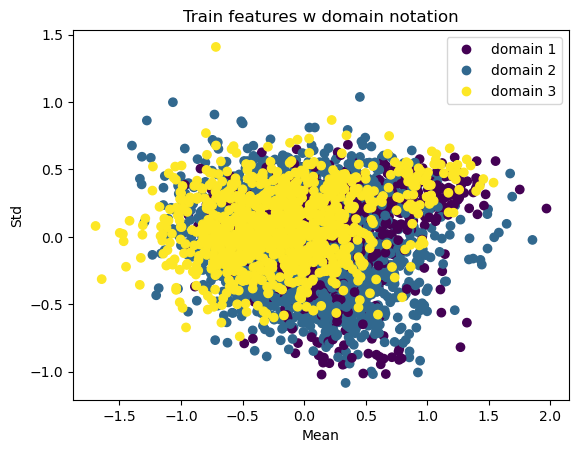

In [28]:
tsne_data = np.hstack((total_mean, total_std))
tsne = PCA(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)
domain_idx = ['domain 1', 'domain 2', 'domain 3', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=domain_idx)
plt.title('Train features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [29]:
np.savetxt('vlcs_train=labelme_pascal=sun.csv', transformed_data, delimiter=',', fmt='%.2f', header='x,y', comments='')

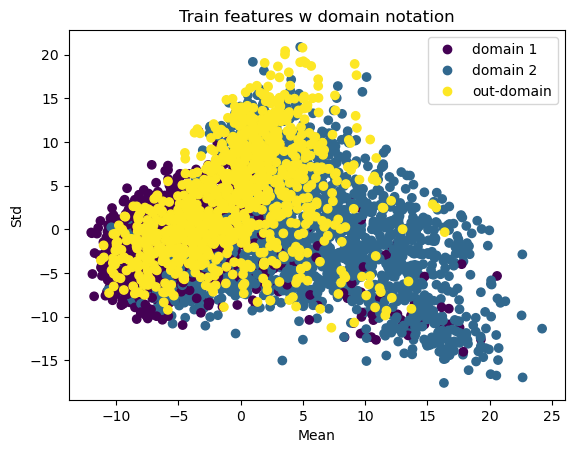

In [32]:
tsne_data = np.hstack((feats_mean, feats_std))
tsne = PCA(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)
domain_idx = ['domain 1', 'domain 2', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=domain_idx)
plt.title('Train features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

/tmp/ipykernel_1616001/3263288923.py:6: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 7
  plt.legend(handles=scatter.legend_elements()[0], labels=label_idx)


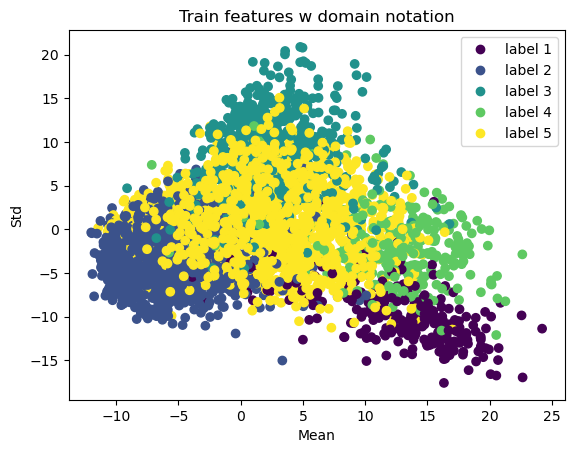

In [31]:
tsne_data = np.hstack((feats_mean, feats_std))
tsne = PCA(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)
label_idx = ['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=label_idx)
plt.title('Train features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()